### Ecobici Challenge: Buenos Aires Bicycle's adoption
"The BsAs bicycle company wants to increase in 18% for the current year the adoption rate of bike rides and in consequence bike stations with available bicycles"

### Datasets
- trips_2023.csv : Bike rides in 2023
- nuevas-estaciones-bicicletas-publicas.geojson : Bike stations
- mecanica-sencilla.xlsx : Bike repair points
- barrios.geojson : Buenos Aires neighbourhoods



### Assumptions:
- Unless otherwise specified, the origin station will be used by default for calculations
- The field "Anclajes" refers to bike parking spots and NOT the total bikes in the bike-sharing system
- There is no avaiable info on the total number of bikes on the bike-sharing system, public information indicates aporx 4000 bikes, that will be used as an estimate
- Due to lack of data, we will assume all bikes are operational, similar in age, and have an equal breakdown probability

### Libraries

In [1]:
## Data analysis libraries
import pandas as pd
import numpy as np

## Geo data analysis libraries
import geopandas as gpd
from shapely.geometry import Point
from geopy.distance import geodesic
from shapely.ops import nearest_points

## Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objs as go
import matplotlib.colors as mcolors


### EDA & Data wrangling

#### Rides dataset

In [2]:
df_trips_2023 = pd.read_csv('C:\\Users\\Ivan Kenigsberg\\Desktop\\trips_2023.csv',sep=',')


In [3]:
df_trips_2023.shape

(2622331, 18)

In [4]:
df_trips_2023_copy = df_trips_2023.copy()

In [5]:
df_trips_2023_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2622331 entries, 0 to 2622330
Data columns (total 18 columns):
 #   Column                      Dtype  
---  ------                      -----  
 0   Unnamed: 0                  int64  
 1   Id_recorrido                object 
 2   duracion_recorrido          object 
 3   fecha_origen_recorrido      object 
 4   id_estacion_origen          object 
 5   nombre_estacion_origen      object 
 6   direccion_estacion_origen   object 
 7   long_estacion_origen        float64
 8   lat_estacion_origen         float64
 9   fecha_destino_recorrido     object 
 10  id_estacion_destino         object 
 11  nombre_estacion_destino     object 
 12  direccion_estacion_destino  object 
 13  long_estacion_destino       float64
 14  lat_estacion_destino        float64
 15  id_usuario                  object 
 16  modelo_bicicleta            object 
 17  género                      object 
dtypes: float64(4), int64(1), object(13)
memory usage: 360.1+ MB


In [6]:
df_trips_2023_copy.head()

,Unnamed: 0,Id_recorrido,duracion_recorrido,fecha_origen_recorrido,id_estacion_origen,nombre_estacion_origen,direccion_estacion_origen,long_estacion_origen,lat_estacion_origen,fecha_destino_recorrido,id_estacion_destino,nombre_estacion_destino,direccion_estacion_destino,long_estacion_destino,lat_estacion_destino,id_usuario,modelo_bicicleta,género
0,1,17910696BAEcobici,"1,848",2023-04-24 10:30:10,358BAEcobici,249 - Balbín,2519 Conesa,-58.465586,-34.561486,2023-04-24 11:00:58,278BAEcobici,233 - MONROE,2519 Superi,-58.469813,-34.564122,861866BAEcobici,ICONIC,MALE
1,2,17600256BAEcobici,288,2023-03-22 17:40:55,444BAEcobici,061 - Ministerio de Economia,"Balcarce e Yrigoyen, Hipolito Av.",-58.370716,-34.608936,2023-03-22 17:45:43,3BAEcobici,003 - ADUANA,Moreno & Azopardo,-58.368174,-34.611102,217525BAEcobici,ICONIC,FEMALE
2,3,17255670BAEcobici,"1,103",2023-02-15 23:12:22,280BAEcobici,222 - SIMON BOLIVAR,"1701 Fernandez Moreno, Baldomero",-58.449379,-34.633528,2023-02-15 23:30:45,280BAEcobici,222 - SIMON BOLIVAR,"1701 Fernandez Moreno, Baldomero",-58.449379,-34.633528,954201BAEcobici,ICONIC,MALE
3,4,17996972BAEcobici,"1,165",2023-05-03 11:00:20,273BAEcobici,223 - GAINZA,"494 Gainza, Martin De, Gral.",-58.446751,-34.616758,2023-05-03 11:19:45,367BAEcobici,287 - Belaustegui,"Belaustegui, Luis, Dr. 2890",-58.477209,-34.616212,179414BAEcobici,ICONIC,MALE
4,5,17148836BAEcobici,378,2023-02-06 06:50:58,65BAEcobici,065 - Julián Álvarez,3822 Guemes,-58.415787,-34.587312,2023-02-06 06:57:16,14BAEcobici,014 - Pacifico,"Santa Fe Av. & Bullrich, Int. Av.",-58.426387,-34.577424,8098BAEcobici,ICONIC,MALE


In [7]:
## Check for null values
df_trips_2023_copy.isnull().sum()

Unnamed: 0                        0
Id_recorrido                      0
duracion_recorrido                0
fecha_origen_recorrido            0
id_estacion_origen                0
nombre_estacion_origen            0
direccion_estacion_origen         0
long_estacion_origen              0
lat_estacion_origen               0
fecha_destino_recorrido           0
id_estacion_destino               2
nombre_estacion_destino           2
direccion_estacion_destino        2
long_estacion_destino             2
lat_estacion_destino              2
id_usuario                        0
modelo_bicicleta                  0
género                        11966
dtype: int64

In [8]:
## Check for duplicates
df_trips_2023_copy.duplicated().any()

False

In [9]:
#Rename column
df_trips_2023_copy = df_trips_2023_copy.rename(columns={'Unnamed: 0': 'row_id'})

In [10]:
## Parse and create columns for trip in sec, min and hs
df_trips_2023_copy['duracion_recorrido'] = df_trips_2023_copy['duracion_recorrido'].str.replace(',', '').astype(float)
df_trips_2023_copy = df_trips_2023_copy.rename(columns={'duracion_recorrido': 'duracion_recorrido_seconds'})
df_trips_2023_copy['duracion_recorrido_minutes'] = df_trips_2023_copy['duracion_recorrido_seconds'] / 60
df_trips_2023_copy['duracion_recorrido_hours'] = df_trips_2023_copy['duracion_recorrido_seconds'] / 3600

In [11]:
# Convert to datetime format
df_trips_2023_copy['fecha_origen_recorrido'] = pd.to_datetime(df_trips_2023_copy['fecha_origen_recorrido'])
df_trips_2023_copy['fecha_destino_recorrido'] = pd.to_datetime(df_trips_2023_copy['fecha_destino_recorrido'])

In [12]:
# Extranct and transform datetime columns
df_trips_2023_copy['week'] = df_trips_2023_copy['fecha_origen_recorrido'].dt.isocalendar().week.astype(int)
df_trips_2023_copy['day_of_week'] = df_trips_2023_copy['fecha_origen_recorrido'].dt.isocalendar().day.astype(int)
df_trips_2023_copy['hour'] = df_trips_2023_copy['fecha_origen_recorrido'].dt.hour.astype(int)
df_trips_2023_copy['year_month'] = df_trips_2023_copy['fecha_origen_recorrido'].dt.strftime('%Y-%m')
day_mapping = {1: 'Mo', 2: 'Tu', 3: 'We', 4: 'Th', 5: 'Fr', 6: 'Sa', 7: 'Su'}
df_trips_2023_copy['day_abbr'] = df_trips_2023_copy['day_of_week'].map(day_mapping)

In [13]:
# Concatenate start and end station to find most popular rides
df_trips_2023_copy['recorrido'] = df_trips_2023_copy['id_estacion_origen'] + df_trips_2023_copy['id_estacion_destino']

In [14]:
## Extract station ID to join later
df_trips_2023_copy['origin_station_num'] = df_trips_2023_copy['nombre_estacion_origen'].apply(lambda x: None if '-' not in x or not x.split('-')[0].strip().isdigit() else int(x.split('-')[0].strip()))

In [15]:
## Summary statistics for object data type
df_trips_2023_copy.describe(include='O').T

,count,unique,top,freq
Id_recorrido,2622331,2622331,17910696BAEcobici,1
id_estacion_origen,2622331,364,175BAEcobici,35834
nombre_estacion_origen,2622331,365,147 - Constitución,35834
direccion_estacion_origen,2622331,370,Avenida Juan de Garay 1050,35834
id_estacion_destino,2622329,365,14BAEcobici,31863
nombre_estacion_destino,2622329,366,014 - Pacifico,31863
direccion_estacion_destino,2622329,371,"Santa Fe Av. & Bullrich, Int. Av.",31863
id_usuario,2622331,212068,668737BAEcobici,1122
modelo_bicicleta,2622331,2,FIT,1655149
género,2610365,3,MALE,1580419


In [16]:
## Summary statistics for numeric data type
selected_columns = ['duracion_recorrido_seconds', 'duracion_recorrido_minutes', 'duracion_recorrido_hours','week','day_of_week','hour']
df_trips_2023_copy[selected_columns].describe().round(1).T

,count,mean,std,min,25%,50%,75%,max
duracion_recorrido_seconds,2622331.0,1380.6,12427.9,61.0,572.0,932.0,1513.0,6208259.0
duracion_recorrido_minutes,2622331.0,23.0,207.1,1.0,9.5,15.5,25.2,103471.0
duracion_recorrido_hours,2622331.0,0.4,3.5,0.0,0.2,0.3,0.4,1724.5
week,2622331.0,26.4,15.6,1.0,12.0,26.0,40.0,52.0
day_of_week,2622331.0,3.5,1.8,1.0,2.0,3.0,5.0,7.0
hour,2622331.0,14.2,5.3,0.0,11.0,15.0,18.0,23.0


#### Rides dataset - Rides & Station analysis

In [17]:
## Average ride duration
print("Average ride duration (seconds):", round(df_trips_2023_copy['duracion_recorrido_seconds'].mean(), 1))
print("Average ride duration (minutes):", round(df_trips_2023_copy['duracion_recorrido_minutes'].mean(), 1))
print("Average ride duration (hours):", round(df_trips_2023_copy['duracion_recorrido_hours'].mean(), 1))


Average ride duration (seconds): 1380.6
Average ride duration (minutes): 23.0
Average ride duration (hours): 0.4


In [18]:
## Median ride duration
print("Median ride duration (minutes):",round(df_trips_2023_copy['duracion_recorrido_minutes'].median(),1))

Median ride duration (minutes): 15.5


In [19]:
## Most popular hours
hourly_count = df_trips_2023_copy.groupby('hour').size().reset_index(name='total')
hourly_count['percentage'] = round((hourly_count['total']/hourly_count['total'].sum())*100,2)
hourly_count

,hour,total,percentage
0,0,49222,1.88
1,1,34678,1.32
2,2,19860,0.76
3,3,11355,0.43
4,4,10043,0.38
5,5,21969,0.84
6,6,48049,1.83
7,7,99798,3.81
8,8,129717,4.95
9,9,112166,4.28


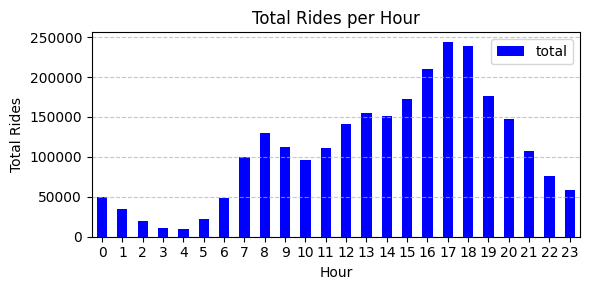

In [20]:
## Total rides per hour
hourly_count.plot(kind='bar', x='hour', y='total', color='blue', figsize=(6,3))
plt.xlabel('Hour')
plt.ylabel('Total Rides')
plt.title('Total Rides per Hour')
plt.xticks(rotation=0) 
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

The mainstream hours go from 4pm to 7pm, with 26% of trips

In [21]:
## Most popular days
daily_count = df_trips_2023_copy.groupby('day_of_week').size().reset_index(name='total')
daily_count['percentage'] = round((daily_count['total']/daily_count['total'].sum())*100,2)
daily_count

,day_of_week,total,percentage
0,1,438908,16.74
1,2,462266,17.63
2,3,477729,18.22
3,4,465783,17.76
4,5,423374,16.14
5,6,178703,6.81
6,7,175568,6.70


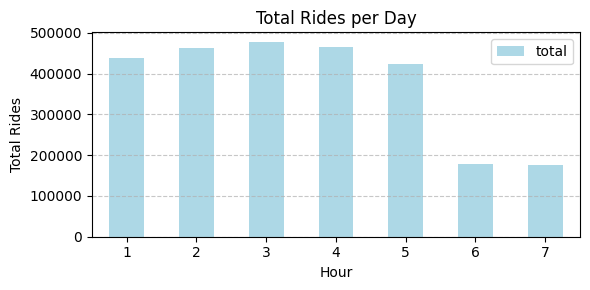

In [22]:
## Total rides per day
daily_count.plot(kind='bar', x='day_of_week', y='total', color='lightblue', figsize=(6,3))
plt.xlabel('Hour')
plt.ylabel('Total Rides')
plt.title('Total Rides per Day')
plt.xticks(rotation=0)  # Rotate x-axis labels if needed
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

The mainstream days are the week days, being Wednesay the one with most rides with 18% of total, closely followed by Tuesday and Thursday

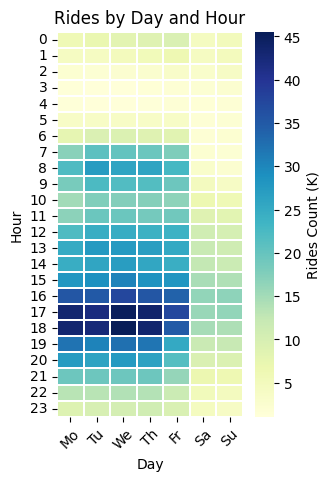

In [23]:
## Combination of most popular days and hour
pivot_table = df_trips_2023_copy.pivot_table(index='hour', columns='day_abbr', aggfunc='size', fill_value=0)

pivot_table = pivot_table[['Mo', 'Tu', 'We', 'Th', 'Fr', 'Sa', 'Su']]
pivot_table = pivot_table / 1000

plt.figure(figsize=(3, 5))
sns.heatmap(pivot_table, cmap='YlGnBu', cbar_kws={'label': 'Rides Count (K)'}, linewidths=0.2)
plt.title('Rides by Day and Hour')
plt.xlabel('Day')
plt.ylabel('Hour')
plt.xticks(rotation=45)
plt.yticks(rotation=0)  
plt.show()

In [24]:
avg_rides_week = df_trips_2023_copy['row_id'].count()/df_trips_2023_copy['week'].nunique()
print("Average rides per week:",round(avg_rides_week,1))

Average rides per week: 50429.4


In [25]:
rides_per_month = df_trips_2023_copy.groupby('year_month')['Id_recorrido'].nunique().reset_index()
print("Average rides per week:",round(rides_per_month['Id_recorrido'].mean(),1))

Average rides per week: 218527.6


In [26]:
rides_per_month

,year_month,Id_recorrido
0,2023-01,242310
1,2023-02,222215
2,2023-03,257641
3,2023-04,218972
4,2023-05,196620
5,2023-06,176599
6,2023-07,163536
7,2023-08,211861
8,2023-09,216713
9,2023-10,247631


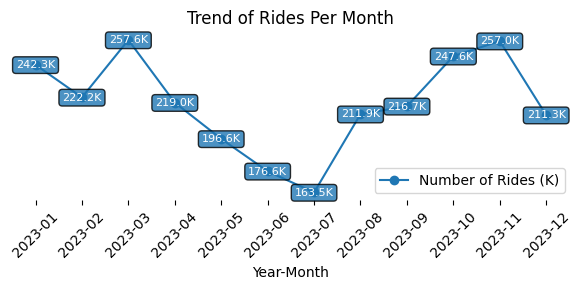

In [27]:
# Plot rides trend line by month
plt.figure(figsize=(6, 3))  
plt.plot(rides_per_month['year_month'], rides_per_month['Id_recorrido'] / 1000, marker='o', label='Number of Rides (K)')  # Divide by 1000 to show values in K

line_color = plt.gca().lines[0].get_color()
lighter_line_color = mcolors.to_rgba(line_color, alpha=0.5)

for i, (year_month, rides) in enumerate(zip(rides_per_month['year_month'], rides_per_month['Id_recorrido'] / 1000)):
    plt.text(year_month, rides - 0.2, f'{rides:.1f}K', ha='center', va='center', fontsize=8, color='white', bbox=dict(facecolor=lighter_line_color, edgecolor='black', alpha=0.8, boxstyle='round'))  # Adjusted label position, text color, and border

plt.xlabel('Year-Month')
plt.ylabel('')
plt.title('Trend of Rides Per Month')

plt.gca().axes.yaxis.set_visible(False)

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['left'].set_visible(False)

plt.xticks(rotation=45)

plt.legend(loc='lower right')

plt.tight_layout()
plt.show()

In [28]:
### Users by month
monthly_usage = df_trips_2023_copy.groupby('year_month')['id_usuario'].nunique().reset_index()
monthly_usage


,year_month,id_usuario
0,2023-01,48738
1,2023-02,49204
2,2023-03,50285
3,2023-04,48069
4,2023-05,44562
5,2023-06,40873
6,2023-07,39773
7,2023-08,39864
8,2023-09,43430
9,2023-10,52441


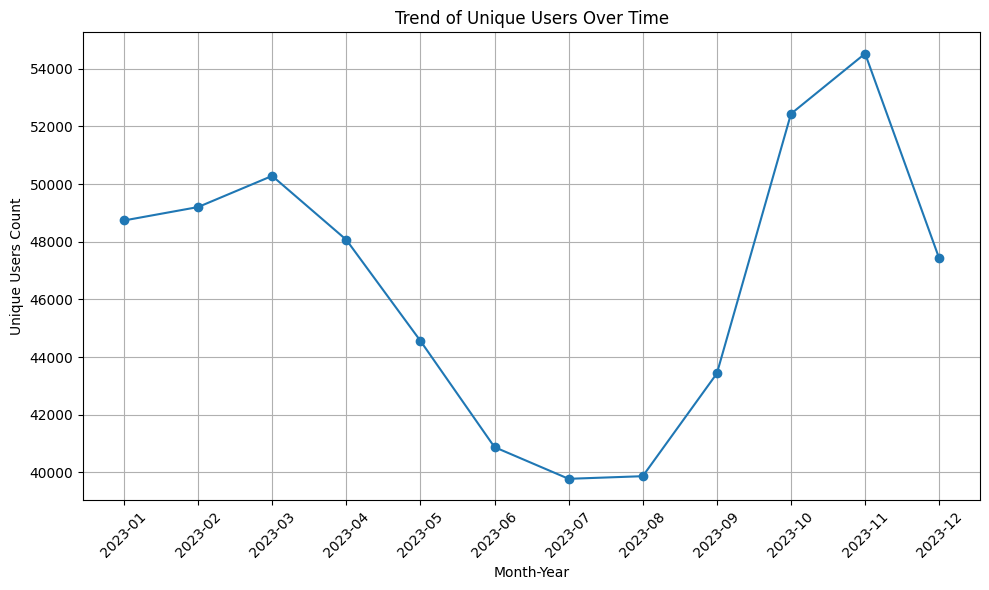

In [29]:
# Plot users trend line by month
plt.figure(figsize=(10, 6))
plt.plot(monthly_usage['year_month'], monthly_usage['id_usuario'], marker='o', linestyle='-')

plt.xlabel('Month-Year')
plt.ylabel('Unique Users Count')
plt.title('Trend of Unique Users Over Time')

plt.xticks(rotation=45)

plt.grid(True)
plt.tight_layout()
plt.show()

Most Trending Stations

Trendings station will be considered in two different ways:

1- Top 10 stations with most count of rides
2- Stations with more increase of rides betwen H1 and H2 2023

This way will consider the most popular ones all year round and the ones that its popularity is increasing.

Popular stations

In [30]:
### Most popular origin stations

count_by_origin = df_trips_2023_copy.groupby('id_estacion_origen')['id_estacion_origen'].count().reset_index(name='total')
top10_origin_stations = count_by_origin.sort_values(by='total',ascending=False).head(10).reset_index()
top10_origin_stations

,index,id_estacion_origen,total
0,49,175BAEcobici,35834
1,29,14BAEcobici,31698
2,354,8BAEcobici,27249
3,328,5BAEcobici,24924
4,70,202BAEcobici,22779
5,17,130BAEcobici,22213
6,323,54BAEcobici,21812
7,136,289BAEcobici,21660
8,15,128BAEcobici,21034
9,32,152BAEcobici,20914


In [31]:
### Most popular end stations

count_by_destination = df_trips_2023_copy.groupby('id_estacion_destino')['id_estacion_destino'].count().reset_index(name='total')
top10_destination_stations = count_by_destination.sort_values(by='total',ascending=False).head(10).reset_index()
top10_destination_stations

,index,id_estacion_destino,total
0,29,14BAEcobici,31863
1,49,175BAEcobici,28624
2,355,8BAEcobici,27196
3,329,5BAEcobici,25048
4,70,202BAEcobici,23189
5,32,152BAEcobici,22639
6,136,289BAEcobici,22057
7,324,54BAEcobici,21790
8,17,130BAEcobici,21737
9,364,9BAEcobici,21319


In [32]:
## Convert to set to make comparison

set_origin = set(top10_origin_stations['id_estacion_origen'])
set_destination = set(top10_destination_stations['id_estacion_destino'])

if set_origin == set_destination:
    print("Most trendring start stations are the same as most trendnig destination stations")
else:
    print("Not")    

Not


In [33]:
# Calculate the percentage similarity
common_elements = len(set_origin.intersection(set_destination))
total_unique_elements = len(set_origin.union(set_destination))
percentage_similarity = (common_elements / total_unique_elements) * 100

print("Percentage similarity:",round(percentage_similarity,1))

Percentage similarity: 81.8


In [34]:
## Find the different stations
elements_in_set1_not_in_set2 = set_origin.difference(set_destination)
elements_in_set2_not_in_set1 = set_destination.difference(set_origin)

print("Elements in set1 but not in set2:", elements_in_set1_not_in_set2)
print("Elements in set2 but not in set1:", elements_in_set2_not_in_set1)

Elements in set1 but not in set2: {'128BAEcobici'}
Elements in set2 but not in set1: {'9BAEcobici'}


In [35]:
## Mosts common rides
count_by_recorrido = df_trips_2023_copy.groupby('recorrido')['recorrido'].count().reset_index(name='total')
count_by_recorrido.sort_values(by='total',ascending=False).head(10)


,recorrido,total
7596,152BAEcobici152BAEcobici,4046
68536,5BAEcobici5BAEcobici,2439
6895,14BAEcobici14BAEcobici,2391
43486,379BAEcobici379BAEcobici,2345
6962,14BAEcobici239BAEcobici,2178
53223,458BAEcobici458BAEcobici,2086
24504,242BAEcobici202BAEcobici,2050
16946,202BAEcobici202BAEcobici,2033
18613,210BAEcobici210BAEcobici,2019
51816,448BAEcobici130BAEcobici,2015


In [36]:
## Add the name for visualization
count_by_origin_name = df_trips_2023_copy.groupby('nombre_estacion_origen')['nombre_estacion_origen'].count().reset_index(name='total')
top10_origin_stations_name = count_by_origin_name.sort_values(by='total',ascending=False).head(10).reset_index()
top10_origin_stations_name

,index,nombre_estacion_origen,total
0,144,147 - Constitución,35834
1,14,014 - Pacifico,31698
2,8,008 - Congreso,27249
3,5,005 - Plaza Italia,24924
4,1,001 - FACULTAD DE DERECHO,22779
5,130,130 - RETIRO II,22213
6,55,054 - Acuña de Figueroa,21812
7,239,255 - BARRANCAS DE BELGRANO,21660
8,128,128 - PARQUE DEL BAJO,21034
9,149,152 - JULIETA LANTERI,20914


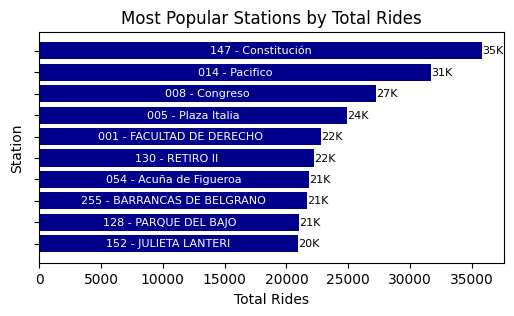

In [37]:
### Horizontal bar chart for origin stations
plt.figure(figsize=(6, 3))
bars = plt.barh(range(len(top10_origin_stations_name)), top10_origin_stations_name['total'], color='darkblue')

for i, bar in enumerate(bars):
    width = bar.get_width()
    station_name = top10_origin_stations_name['nombre_estacion_origen'][i]
    plt.text(width / 2, i, f'{station_name}', va='center', ha='center', fontsize=8, color='white')

    plt.text(width, i, f'{int(width/1000)}K', va='center', ha='left', fontsize=8, color='black')

plt.xlabel('Total Rides')
plt.ylabel('Station')
plt.title('Most Popular Stations by Total Rides')
plt.yticks(range(len(top10_origin_stations_name)), '')  
plt.gca().invert_yaxis() 
plt.show()

Trending Stations

In [38]:
## Define periods por comparison
h1_start = pd.Timestamp('2023-01-01')
h1_end = pd.Timestamp('2023-06-30')
h2_start = pd.Timestamp('2023-07-01')
h2_end = pd.Timestamp('2023-12-31')

In [39]:
## Create datasets
rides_h1 = df_trips_2023_copy[(df_trips_2023_copy['fecha_origen_recorrido'] >= h1_start) & (df_trips_2023_copy['fecha_origen_recorrido'] <= h1_end)]
rides_h2 = df_trips_2023_copy[(df_trips_2023_copy['fecha_origen_recorrido'] >= h2_start) & (df_trips_2023_copy['fecha_origen_recorrido'] <= h2_end)]

In [40]:
## Count stations for each dataset
ride_counts_h1_ori = rides_h1['id_estacion_origen'].value_counts().reset_index().rename(columns={'index': 'id_estacion_origen', 'id_estacion_origen': 'rides_h1'})
ride_counts_h2_ori = rides_h2['id_estacion_origen'].value_counts().reset_index().rename(columns={'index': 'id_estacion_origen', 'id_estacion_origen': 'rides_h2'})

In [41]:
## Left join data set to see increase
ride_counts_ori = ride_counts_h1_ori.merge(ride_counts_h2_ori, on='id_estacion_origen', how='left').fillna(0)

In [42]:
## Increase calculation
ride_counts_ori['increase'] = ride_counts_ori['rides_h2'] - ride_counts_ori['rides_h1']

In [43]:
## Keep 10 with more increase
trending_stations_ori = ride_counts_ori.nlargest(10, 'increase')['id_estacion_origen']

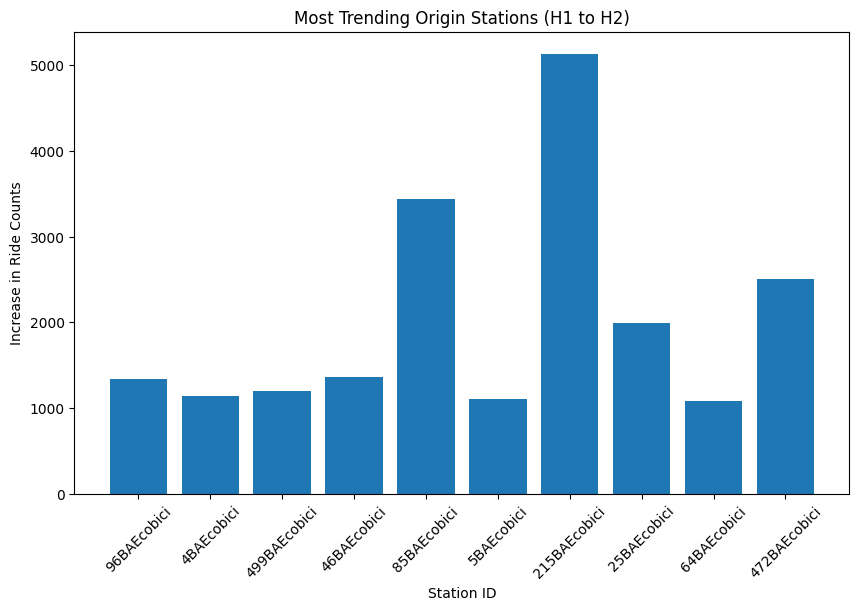

In [44]:
## Trending origin stations
plt.figure(figsize=(10, 6))
plt.bar(trending_stations_ori, ride_counts_ori.loc[ride_counts_ori['id_estacion_origen'].isin(trending_stations_ori), 'increase'])
plt.xlabel('Station ID')
plt.ylabel('Increase in Ride Counts')
plt.title('Most Trending Origin Stations (H1 to H2)')
plt.xticks(rotation=45)
plt.show()

In [45]:
## Repeat the process for destination stations
ride_counts_h1_dest = rides_h1['id_estacion_destino'].value_counts().reset_index().rename(columns={'index': 'id_estacion_destino', 'id_estacion_destino': 'rides_h1'})
ride_counts_h2_dest = rides_h2['id_estacion_destino'].value_counts().reset_index().rename(columns={'index': 'id_estacion_destino', 'id_estacion_destino': 'rides_h2'})

In [46]:
ride_counts_dest = ride_counts_h1_dest.merge(ride_counts_h2_dest, on='id_estacion_destino', how='outer').fillna(0)

In [47]:
ride_counts_dest['increase'] = ride_counts_dest['rides_h2'] - ride_counts_dest['rides_h1']

In [48]:
trending_stations_dest = ride_counts_dest.nlargest(10, 'increase')['id_estacion_destino']

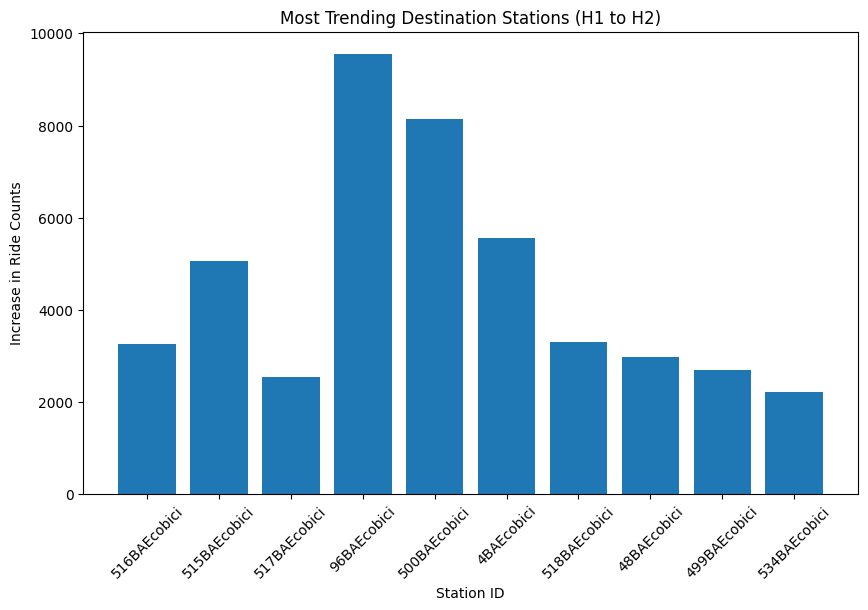

In [49]:
plt.figure(figsize=(10, 6))
plt.bar(trending_stations_dest, ride_counts_dest.loc[ride_counts_dest['id_estacion_destino'].isin(trending_stations_dest), 'increase'])
plt.xlabel('Station ID')
plt.ylabel('Increase in Ride Counts')
plt.title('Most Trending Destination Stations (H1 to H2)')
plt.xticks(rotation=45)
plt.show()

In [50]:
## Convert to set to make comparison
set_trending_origin = set(trending_stations_ori)
set_trending_destination = set(trending_stations_dest)

if set_trending_origin == set_trending_destination:
    print("Most trendring start stations are the same as most trendnig destination stations")
else:
    print("Not")  

Not


The problem is that there can be new stations...

In [51]:
## Check if the stations are new

list_of_stations_ori = trending_stations_ori.tolist()
trending_stations_filtered_trips = df_trips_2023_copy[df_trips_2023_copy['id_estacion_origen'].isin(list_of_stations_ori)]
trending_stations_min_dates = trending_stations_filtered_trips.groupby('id_estacion_origen')['fecha_origen_recorrido'].min()
trending_stations_min_dates


id_estacion_origen
215BAEcobici   2023-01-01 00:58:34
25BAEcobici    2023-01-01 01:25:06
46BAEcobici    2023-03-08 01:21:33
472BAEcobici   2023-03-10 09:41:42
499BAEcobici   2023-05-21 16:50:34
4BAEcobici     2023-01-01 01:07:04
5BAEcobici     2023-01-01 00:22:33
64BAEcobici    2023-01-01 05:29:30
85BAEcobici    2023-01-01 01:30:11
96BAEcobici    2023-01-01 00:32:17
Name: fecha_origen_recorrido, dtype: datetime64[ns]

In [52]:
## Check until when there were new stations

stations_min_dates= df_trips_2023_copy.groupby('id_estacion_origen')['fecha_origen_recorrido'].min().reset_index()

last_station = stations_min_dates['fecha_origen_recorrido'].max()

last_station

Timestamp('2023-11-14 16:13:33')

In [53]:
stations_min_dates['year_month'] = stations_min_dates['fecha_origen_recorrido'].dt.strftime('%Y-%m')

In [54]:
## Check new stations by month
new_stations = stations_min_dates.groupby('year_month')['fecha_origen_recorrido'].count().reset_index()
new_stations

,year_month,fecha_origen_recorrido
0,2023-01,314
1,2023-02,3
2,2023-03,3
3,2023-04,1
4,2023-05,1
5,2023-07,18
6,2023-08,1
7,2023-09,12
8,2023-10,10
9,2023-11,1


Last new station was in November, just one, so I'll use the increase from december to november to see the most trending stations

In [55]:
## Repeat the process for Nov vs Dec
m11_start = pd.Timestamp('2023-11-01')
m11_end = pd.Timestamp('2023-11-30')
m12_start = pd.Timestamp('2023-12-01')
m12_end = pd.Timestamp('2023-12-31')

In [56]:
rides_m11 = df_trips_2023_copy[(df_trips_2023_copy['fecha_origen_recorrido'] >= m11_start) & (df_trips_2023_copy['fecha_origen_recorrido'] <= m11_end)]
rides_m12 = df_trips_2023_copy[(df_trips_2023_copy['fecha_origen_recorrido'] >= m12_start) & (df_trips_2023_copy['fecha_origen_recorrido'] <= m12_end)]

In [57]:
ride_counts_m11_ori = rides_m11['nombre_estacion_origen'].value_counts().reset_index().rename(columns={'index': 'nombre_estacion_origen', 'nombre_estacion_origen': 'rides_m11'})
ride_counts_m12_ori = rides_m12['nombre_estacion_origen'].value_counts().reset_index().rename(columns={'index': 'nombre_estacion_origen', 'nombre_estacion_origen': 'rides_m12'})

In [58]:
ride_counts_m_ori = ride_counts_m11_ori.merge(ride_counts_m12_ori, on='nombre_estacion_origen', how='outer').fillna(0)
ride_counts_m_ori['increase'] = ride_counts_m_ori['rides_m12'] - ride_counts_m_ori['rides_m11']
ride_counts_m_ori['increase'].astype(int)
trending_stations_m_ori = ride_counts_m_ori.nlargest(10, 'increase')['nombre_estacion_origen']
ride_counts_m_ori_sorted = ride_counts_m_ori.sort_values(by='increase', ascending=False)

([], [])

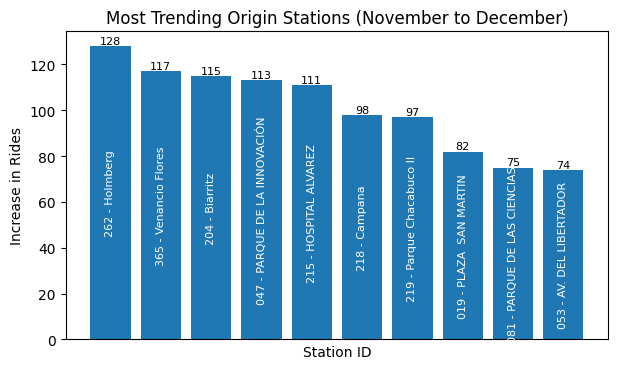

In [59]:
plt.figure(figsize=(7, 4))
bars = plt.bar(trending_stations_m_ori, ride_counts_m_ori_sorted.loc[ride_counts_m_ori_sorted['nombre_estacion_origen'].isin(trending_stations_m_ori), 'increase'])

for bar, station, increase in zip(bars, trending_stations_m_ori, ride_counts_m_ori_sorted.loc[ride_counts_m_ori_sorted['nombre_estacion_origen'].isin(trending_stations_m_ori), 'increase']):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() / 2, station, ha='center', va='center', fontsize=8, rotation=90, color='white')
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{int(increase)}', ha='center', va='bottom', fontsize=8, rotation=0, color='black')

plt.xlabel('Station ID')
plt.ylabel('Increase in Rides')
plt.title('Most Trending Origin Stations (November to December)')
plt.xticks([])  

In [60]:
ride_counts_m11_dest = rides_m11['id_estacion_destino'].value_counts().reset_index().rename(columns={'index': 'id_estacion_destino', 'id_estacion_destino': 'rides_m11'})
ride_counts_m12_dest = rides_m12['id_estacion_destino'].value_counts().reset_index().rename(columns={'index': 'id_estacion_destino', 'id_estacion_destino': 'rides_m12'})

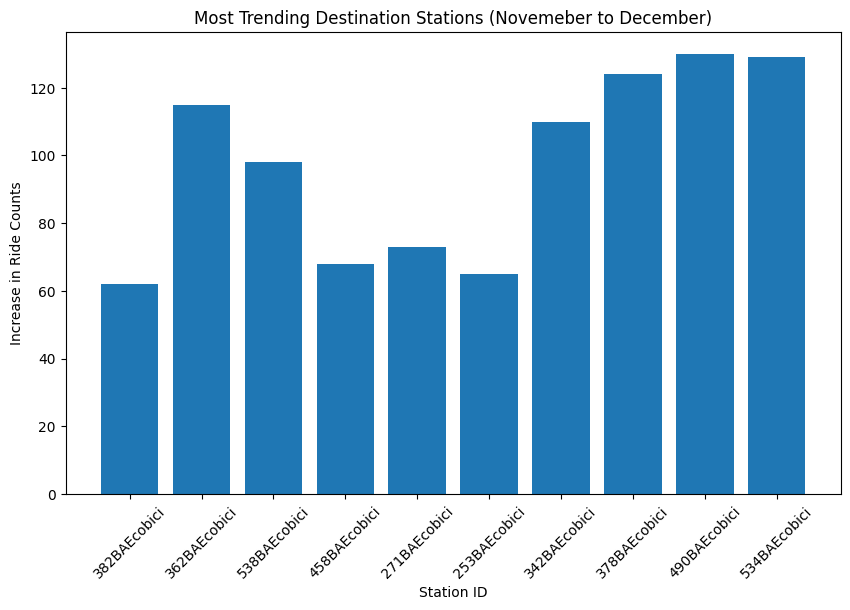

In [61]:
ride_counts_m_dest = ride_counts_m11_dest.merge(ride_counts_m12_dest, on='id_estacion_destino', how='outer').fillna(0)
ride_counts_m_dest['increase'] = ride_counts_m_dest['rides_m12'] - ride_counts_m_dest['rides_m11']

trending_stations_m_dest = ride_counts_m_dest.nlargest(10, 'increase')['id_estacion_destino']

plt.figure(figsize=(10, 6))
plt.bar(trending_stations_m_dest, ride_counts_m_dest.loc[ride_counts_m_dest['id_estacion_destino'].isin(trending_stations_m_dest), 'increase'])
plt.xlabel('Station ID')
plt.ylabel('Increase in Ride Counts')
plt.title('Most Trending Destination Stations (Novemeber to December)')
plt.xticks(rotation=45)
plt.show()

In [62]:
## Convert to set to make comparison
set_trending_m_origin = set(trending_stations_m_ori)
set_trending_m_destination = set(trending_stations_m_dest)

if set_trending_m_origin == set_trending_m_destination:
    print("Most trendring start stations are the same as most trendnig destination stations")
else:
    print("Not")  

Not


In [63]:
# Calculate the percentage similarity
common_elements_m = len(set_trending_m_origin.intersection(set_trending_m_destination))

# Calculate the total number of unique elements (union)
total_unique_elements_m = len(set_trending_m_origin.union(set_trending_m_destination))


percentage_similarity_m = (common_elements_m / total_unique_elements_m) * 100

print("Percentage similarity:",round(percentage_similarity_m,1))

Percentage similarity: 0.0


In [64]:
elements_in_set1_not_in_set2_m = set_trending_m_origin.difference(set_trending_m_destination)

elements_in_set2_not_in_set1_m = set_trending_m_destination.difference(set_trending_m_origin)

print("Elements in set1 but not in set2:", elements_in_set1_not_in_set2_m)
print("Elements in set2 but not in set1:", elements_in_set2_not_in_set1_m)

Elements in set1 but not in set2: {'219 - Parque Chacabuco II', '262 - Holmberg', '218 - Campana', '081 - PARQUE DE LAS CIENCIAS', '365 - Venancio Flores', '204 - Biarritz', '053 - AV. DEL LIBERTADOR', '215 - HOSPITAL ALVAREZ', '047 - PARQUE DE LA INNOVACIÓN', '019 - PLAZA  SAN MARTIN'}
Elements in set2 but not in set1: {'538BAEcobici', '342BAEcobici', '271BAEcobici', '378BAEcobici', '534BAEcobici', '458BAEcobici', '253BAEcobici', '362BAEcobici', '490BAEcobici', '382BAEcobici'}


#### Bike stations dataset

El data set 'nuevas-estaciones-bicicletas-publicas.csv' no tiene la cantidad de biciletas por estación, si esta en el geojson.

In [65]:
url_stations = "https://cdn.buenosaires.gob.ar/datosabiertos/datasets/transporte-y-obras-publicas/estaciones-bicicletas-publicas/nuevas-estaciones-bicicletas-publicas.geojson"


In [66]:
gdf_stations = gpd.read_file(url_stations)

In [67]:
gdf_stations_copy = gdf_stations.copy()

In [68]:
gdf_stations_copy.shape

(471, 12)

In [69]:
gdf_stations_copy.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 471 entries, 0 to 470
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   ID          471 non-null    int64   
 1   NUMERO      471 non-null    int64   
 2   NOMBRE      471 non-null    object  
 3   DIRECCION   471 non-null    object  
 4   BARRIO      471 non-null    object  
 5   COMUNA      471 non-null    object  
 6   EMPLAZAMIE  471 non-null    object  
 7   ANCLAJES    471 non-null    int64   
 8   QUEDA_ABIE  471 non-null    int64   
 9   Lat         471 non-null    float64 
 10  Lon         471 non-null    float64 
 11  geometry    471 non-null    geometry
dtypes: float64(2), geometry(1), int64(4), object(5)
memory usage: 44.3+ KB


In [70]:
gdf_stations_copy.isnull().sum()

ID            0
NUMERO        0
NOMBRE        0
DIRECCION     0
BARRIO        0
COMUNA        0
EMPLAZAMIE    0
ANCLAJES      0
QUEDA_ABIE    0
Lat           0
Lon           0
geometry      0
dtype: int64

In [71]:
gdf_stations_copy.head(5)

,ID,NUMERO,NOMBRE,DIRECCION,BARRIO,COMUNA,EMPLAZAMIE,ANCLAJES,QUEDA_ABIE,Lat,Lon,geometry
0,202,1,FACULTAD DE DERECHO,"2120 Figueroa Alcorta, Pres. Av.",RECOLETA,COMUNA 2,VEREDA,30,1,-34.5842,-58.3905,POINT (-58.39050 -34.58420)
1,2,2,RETIRO I,"Ramos Mejia, Jose Maria, Dr. Av. & Del Liberta...",RETIRO,COMUNA 1,PLAZA ABIERTA,36,1,-34.5927,-58.3751,POINT (-58.37510 -34.59270)
2,3,3,ADUANA,Moreno & Azopardo,MONSERRAT,COMUNA 1,VEREDA,20,1,-34.6112,-58.3696,POINT (-58.36960 -34.61120)
3,4,4,PLAZA ROMA,Lavalle & Bouchard,SAN NICOLAS,COMUNA 1,CALZADA,20,1,-34.6018,-58.3691,POINT (-58.36910 -34.60180)
4,5,5,PLAZA ITALIA,2601 Sarmiento Av.,PALERMO,COMUNA 14,VEREDA,42,1,-34.5808,-58.4204,POINT (-58.42040 -34.58080)


In [72]:
### Cantidad de anclajes totales
total_bicis= gdf_stations_copy['ANCLAJES'].sum()
total_bicis

8577

#### Bike repairpoints dataset

In [73]:
df_repairs = pd.read_excel('C:\\Users\\Ivan Kenigsberg\\Desktop\\mecanica-sencilla.xlsx')

In [74]:
df_repairs_copy = df_repairs.copy()

In [75]:
df_repairs_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19 entries, 0 to 18
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   LUGAR                    19 non-null     object 
 1   UBICACION                19 non-null     object 
 2   ESTADO                   19 non-null     object 
 3   LUNES_A_VIERNES          15 non-null     object 
 4   SA_DO_FE                 15 non-null     object 
 5   DIRECCION_NORMALIZADA    18 non-null     object 
 6   CALLE                    18 non-null     object 
 7   ALTURA                   4 non-null      float64
 8   BARRIO                   18 non-null     object 
 9   COMUNA                   18 non-null     object 
 10  CODIGO_POSTAL            4 non-null      float64
 11  CODIGO_POSTAL_ARGENTINO  4 non-null      object 
 12  LAT                      18 non-null     float64
 13  LNG                      18 non-null     float64
dtypes: float64(4), object(10)
me

In [76]:
df_repairs_copy.duplicated().any()

False

In [77]:
df_repairs_copy.isnull().sum()

LUGAR                       0
UBICACION                   0
ESTADO                      0
LUNES_A_VIERNES             4
SA_DO_FE                    4
DIRECCION_NORMALIZADA       1
CALLE                       1
ALTURA                     15
BARRIO                      1
COMUNA                      1
CODIGO_POSTAL              15
CODIGO_POSTAL_ARGENTINO    15
LAT                         1
LNG                         1
dtype: int64

In [78]:
df_repairs_copy = df_repairs_copy.dropna(subset=['LAT', 'LNG'])

In [79]:
## Summary statistics for object data type
df_repairs_copy.describe(include='O').T

,count,unique,top,freq
LUGAR,18,17,PARQUE PATRICIOS,2
UBICACION,18,3,ESTACION SALUDABLE,13
ESTADO,18,1,INSTALADO,18
LUNES_A_VIERNES,14,11,08:00 A 20:00,3
SA_DO_FE,14,3,09:00 A 18:00,10
DIRECCION_NORMALIZADA,18,17,PATAGONES Y MONTEAGUDO,2
CALLE,18,16,PATAGONES,2
BARRIO,18,13,PALERMO,3
COMUNA,18,11,COMUNA 4,5
CODIGO_POSTAL_ARGENTINO,4,4,C1405DCP,1


In [80]:
df_repairs_copy = df_repairs_copy.drop_duplicates(subset=['LUGAR'], keep='first')

In [81]:
df_repairs_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17 entries, 0 to 18
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   LUGAR                    17 non-null     object 
 1   UBICACION                17 non-null     object 
 2   ESTADO                   17 non-null     object 
 3   LUNES_A_VIERNES          14 non-null     object 
 4   SA_DO_FE                 14 non-null     object 
 5   DIRECCION_NORMALIZADA    17 non-null     object 
 6   CALLE                    17 non-null     object 
 7   ALTURA                   4 non-null      float64
 8   BARRIO                   17 non-null     object 
 9   COMUNA                   17 non-null     object 
 10  CODIGO_POSTAL            4 non-null      float64
 11  CODIGO_POSTAL_ARGENTINO  4 non-null      object 
 12  LAT                      17 non-null     float64
 13  LNG                      17 non-null     float64
dtypes: float64(4), object(10)
me

In [82]:
df_repairs_copy.head(3)

,LUGAR,UBICACION,ESTADO,LUNES_A_VIERNES,SA_DO_FE,DIRECCION_NORMALIZADA,CALLE,ALTURA,BARRIO,COMUNA,CODIGO_POSTAL,CODIGO_POSTAL_ARGENTINO,LAT,LNG
0,PARQUE LOS ANDES,ESTACION SALUDABLE,INSTALADO,08:30 A 12:30 Y DE 15:00 A 19:00,09:00 A 18:00,DORREGO AV. Y CORRIENTES AV.,DORREGO AV.,NaN,CHACARITA,COMUNA 15,NaN,NaN,-34.591699,-58.447601
1,PARQUE CENTENARIO,ESTACION SALUDABLE,INSTALADO,08:00 A 12:00 Y DE 14:30 A 18:30,09:00 A 19:00,DIAZ VELEZ AV. 4800,DIAZ VELEZ AV.,4800.0,CABALLITO,COMUNA 6,1405.0,C1405DCP,-34.608666,-58.434804
2,ROSEDAL,ESTACION SALUDABLE,INSTALADO,08:00 A 12:00 Y DE 15:00 A 19:00,09:00 A 18:00,SARMIENTO AV. E IRAOLA AV.,SARMIENTO AV.,NaN,PALERMO,COMUNA 14,NaN,NaN,-34.572146,-58.412468


In [83]:
geometry = [Point(xy) for xy in zip(df_repairs_copy['LNG'], df_repairs_copy['LAT'])]

# Create a GeoDataFrame
gdf_repair_points = gpd.GeoDataFrame(df_repairs_copy, geometry=geometry, crs='EPSG:4326')

In [84]:
gdf_repair_points.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 17 entries, 0 to 18
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   LUGAR                    17 non-null     object  
 1   UBICACION                17 non-null     object  
 2   ESTADO                   17 non-null     object  
 3   LUNES_A_VIERNES          14 non-null     object  
 4   SA_DO_FE                 14 non-null     object  
 5   DIRECCION_NORMALIZADA    17 non-null     object  
 6   CALLE                    17 non-null     object  
 7   ALTURA                   4 non-null      float64 
 8   BARRIO                   17 non-null     object  
 9   COMUNA                   17 non-null     object  
 10  CODIGO_POSTAL            4 non-null      float64 
 11  CODIGO_POSTAL_ARGENTINO  4 non-null      object  
 12  LAT                      17 non-null     float64 
 13  LNG                      17 non-null     float64 
 14  geom

#### Bs As neighbourhoods dataset

In [85]:
url_neighborhood = "https://cdn.buenosaires.gob.ar/datosabiertos/datasets/ministerio-de-educacion/barrios/barrios.geojson"


In [86]:
gdf_neighborhood = gpd.read_file(url_neighborhood)

In [87]:
gdf_neighborhood_copy = gdf_neighborhood.copy()

In [88]:
gdf_neighborhood_copy.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 48 entries, 0 to 47
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   BARRIO     48 non-null     object  
 1   COMUNA     48 non-null     float64 
 2   PERIMETRO  48 non-null     float64 
 3   AREA       48 non-null     float64 
 4   OBJETO     48 non-null     object  
 5   geometry   48 non-null     geometry
dtypes: float64(3), geometry(1), object(2)
memory usage: 2.4+ KB


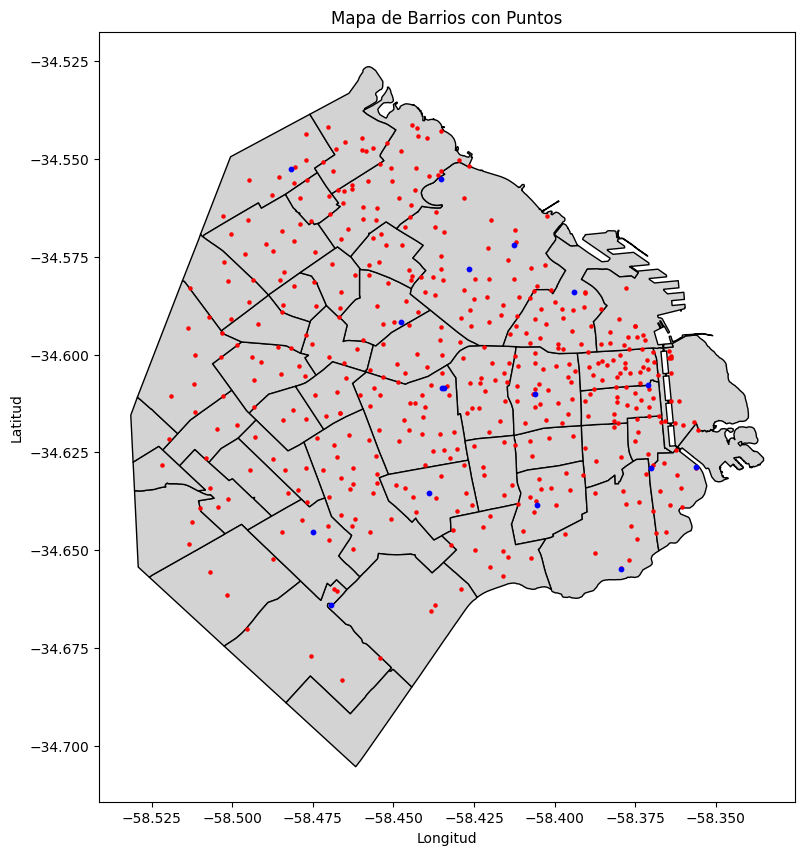

In [89]:
# Plot neighborhoods, bike stations and bike repair points
ax = gdf_neighborhood_copy.plot(figsize=(10, 10), color='lightgray', edgecolor='black')

gdf_stations_copy.plot(ax=ax, color='red', markersize=5)

gdf_repair_points.plot(ax=ax, color='blue', markersize=10)


plt.title('Mapa de Barrios con Puntos')
plt.xlabel('Longitud')
plt.ylabel('Latitud')
plt.show()

In [90]:
### mercado potencial ¿?
### frabjas horarias 

In [91]:
### puntos azules mas grandes

In [92]:
gdf_repair_points.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 17 entries, 0 to 18
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   LUGAR                    17 non-null     object  
 1   UBICACION                17 non-null     object  
 2   ESTADO                   17 non-null     object  
 3   LUNES_A_VIERNES          14 non-null     object  
 4   SA_DO_FE                 14 non-null     object  
 5   DIRECCION_NORMALIZADA    17 non-null     object  
 6   CALLE                    17 non-null     object  
 7   ALTURA                   4 non-null      float64 
 8   BARRIO                   17 non-null     object  
 9   COMUNA                   17 non-null     object  
 10  CODIGO_POSTAL            4 non-null      float64 
 11  CODIGO_POSTAL_ARGENTINO  4 non-null      object  
 12  LAT                      17 non-null     float64 
 13  LNG                      17 non-null     float64 
 14  geom

#### Bikes repair point analysis

How to choose where to put a new repair point for city bikes... Where there is high demand or low supply

In [93]:
# Create a new geodataframe
nearest_points_gdf = pd.DataFrame(columns=['NUMERO', 'LUGAR'])

The function nearest_points comes from the shapely.ops module of the Shapely library in Python. This function is used to find the two nearest points between two Shapely geometries.

Its signature is as follows: nearest_points(geom1, geom2)

Where geom1 and geom2 are Shapely geometric objects (e.g., points, lines, or polygons). This function returns a tuple of two Shapely points, one from geom1 and the other from geom2, which are closest to each other.

This function utilizes the concepts of computational geometry and spatial algorithms to calculate the distance between points and find the two nearest points. It implements efficient algorithms, such as the k-nearest neighbors search algorithm, to find the nearest points.

The term "k-nearest neighbors" (k-NN) is an algorithm used in machine learning and data mining for classification and regression. The basic idea of the algorithm is to find the k nearest points to a query point (also known as the "nearest neighbor") in a dataset, and then use the information from these neighbors to make a prediction or classification.

In [ ]:
# Iterar sobre cada estación de bicicletas
for idx, station in gdf_stations_copy.iterrows():
    # Encontrar el punto de reparación más cercano a la estación de bicicletas actual
    nearest_point, repair_id = nearest_points(station.geometry, gdf_repair_points.geometry.unary_union)
    repair_id = gdf_repair_points[gdf_repair_points.geometry == repair_id]['LUGAR'].values[0] if repair_id is not None else None  # Obtener el ID del punto de reparación más cercano si existe
    # Agregar el ID de la estación y el ID del punto de reparación más cercano al DataFrame de resultados
    nearest_points_gdf = nearest_points_gdf.append({'NUMERO': station['NUMERO'],'LUGAR': repair_id}, ignore_index=True)

print(nearest_points_gdf)

In [95]:
# Count Group by station
summary_by_station = nearest_points_gdf.groupby('LUGAR').size().reset_index(name='count_stration_point')
summary_by_station_sorted = summary_by_station.sort_values(by='count_stration_point', ascending=False)

print(summary_by_station_sorted)

                   LUGAR  count_stration_point
11      PARQUE RIVADAVIA                    59
12       PARQUE SAAVEDRA                    57
9       PARQUE LOS ANDES                    52
4      PARQUE AVELLANEDA                    51
2                   ONCE                    48
6       PARQUE CHACABUCO                    31
1        LAGO DE PALERMO                    29
10      PARQUE PATRICIOS                    25
15           RUBEN DARIO                    24
3               PACIFICO                    18
5      PARQUE CENTENARIO                    16
13                RETIRO                    16
8          PARQUE LEZAMA                    14
14               ROSEDAL                    10
16        USINA DEL ARTE                     8
0                    CMD                     7
7   PARQUE INDOAMERICANO                     6


In [130]:
### Results with location
nearest_points_with_geometry = nearest_points_gdf.merge(gdf_repair_points[['LUGAR', 'geometry']], on='LUGAR', how='left')
print(nearest_points_with_geometry)

    NUMERO              LUGAR                     geometry
0        1        RUBEN DARIO  POINT (-58.39391 -34.58405)
1        2   PARQUE RIVADAVIA  POINT (-58.37109 -34.60778)
2        3   PARQUE RIVADAVIA  POINT (-58.37109 -34.60778)
3        4   PARQUE RIVADAVIA  POINT (-58.37109 -34.60778)
4        5           PACIFICO  POINT (-58.42654 -34.57817)
..     ...                ...                          ...
937    314  PARQUE AVELLANEDA  POINT (-58.47496 -34.64523)
938    266  PARQUE CENTENARIO  POINT (-58.43480 -34.60867)
939     55    PARQUE SAAVEDRA  POINT (-58.48171 -34.55266)
940     41   PARQUE PATRICIOS  POINT (-58.40540 -34.63834)
941     80   PARQUE CHACABUCO  POINT (-58.43886 -34.63525)

[942 rows x 3 columns]


In [97]:
summary_by_station.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17 entries, 0 to 16
Data columns (total 2 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   LUGAR                 17 non-null     object
 1   count_stration_point  17 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 400.0+ bytes


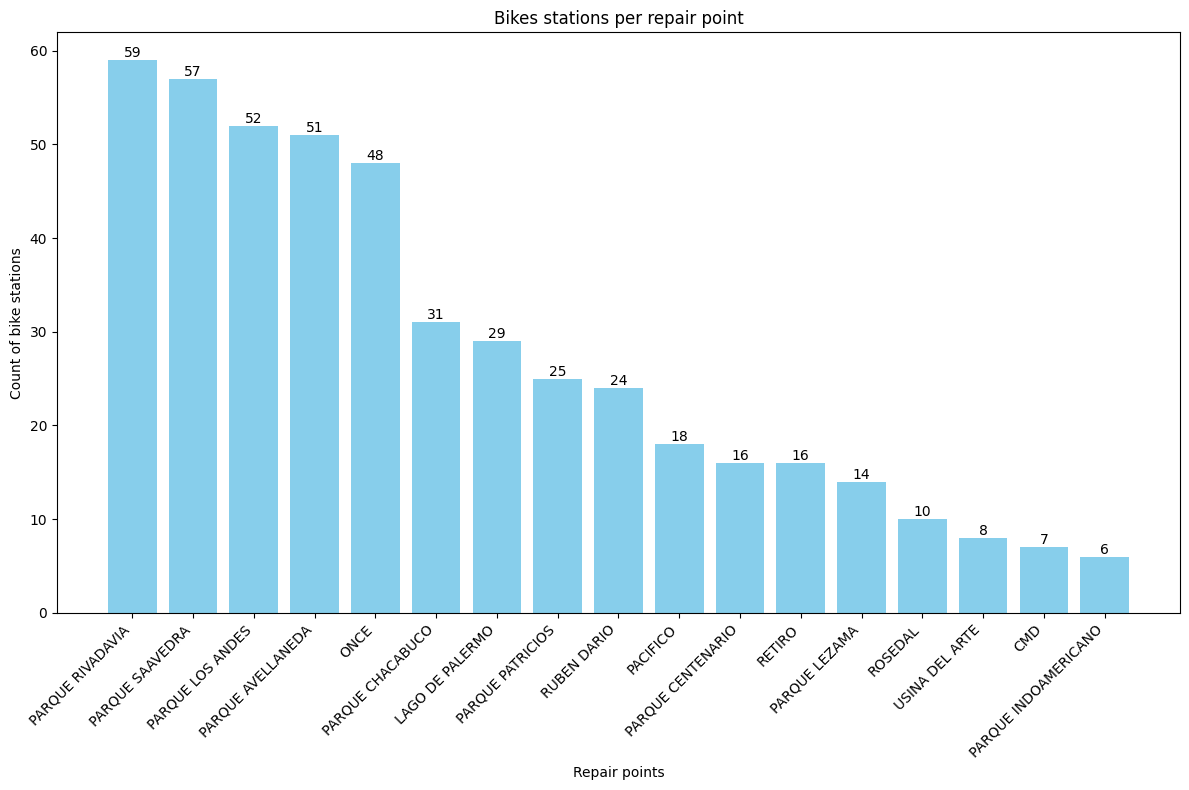

In [129]:
# Plot the results
plt.figure(figsize=(12, 8))
bars = plt.bar(summary_by_station_sorted['LUGAR'], summary_by_station_sorted['count_stration_point'], color='skyblue')

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height, str(height), ha='center', va='bottom')

plt.xlabel('Repair points')
plt.ylabel('Count of bike stations')
plt.title('Bikes stations per repair point')
plt.xticks(rotation=45, ha='right') 
plt.tight_layout()
plt.show()

This is the result to know which repair points have more bike stations near... but it doesnt mean that most of the bikes are there... We need to finde were are most of the bikes so we can capture market share

In [101]:
columns_to_keep = ['Id_recorrido','id_estacion_origen','nombre_estacion_origen','long_estacion_origen','lat_estacion_origen','origin_station_num']
rides_m12_copy = rides_m12[columns_to_keep].copy()


In [102]:
# Get the summary of rides by origin station
rides_summary = rides_m12_copy.groupby('origin_station_num')['Id_recorrido'].size().reset_index()
rides_summary.rename(columns={'Id_recorrido': 'ride_count'}, inplace=True)

rides_summary

,origin_station_num,ride_count
0,1.0,1554
1,2.0,676
2,3.0,1026
3,4.0,1179
4,5.0,2197
...,...,...
349,394.0,232
350,395.0,333
351,396.0,668
352,397.0,197


In [104]:
### Join the results with the rides summary
merged_df = nearest_points_with_geometry.merge(rides_summary, left_on='NUMERO',right_on='origin_station_num', how='left')
merged_df['geometry'] = merged_df['geometry'].astype(str)

In [105]:
repair_points_result = merged_df.groupby(['LUGAR', 'geometry']).agg({'origin_station_num': 'count', 'ride_count': 'sum'}).reset_index()
repair_points_result.rename(columns={'origin_station_num': 'station_count'}, inplace=True)

df_ordered = repair_points_result.sort_values(by='geometry', ascending=False)
df_ordered

,LUGAR,geometry,station_count,ride_count
12,PARQUE SAAVEDRA,POINT (-58.481706 -34.552655),57,18709.0
4,PARQUE AVELLANEDA,POINT (-58.474961 -34.645226),47,15469.0
7,PARQUE INDOAMERICANO,POINT (-58.469238 -34.66387),6,1245.0
9,PARQUE LOS ANDES,POINT (-58.447601 -34.591699),45,19648.0
6,PARQUE CHACABUCO,POINT (-58.438859 -34.63525),23,10159.0
1,LAGO DE PALERMO,POINT (-58.435391 -34.555265),26,13123.0
5,PARQUE CENTENARIO,POINT (-58.434804 -34.608666),12,7469.0
13,RETIRO,POINT (-58.434242 -34.608497),15,12979.0
3,PACIFICO,POINT (-58.426535 -34.578165),16,15498.0
14,ROSEDAL,POINT (-58.412468 -34.572146),10,8002.0


In [106]:
df_ordered.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17 entries, 12 to 16
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   LUGAR          17 non-null     object 
 1   geometry       17 non-null     object 
 2   station_count  17 non-null     int64  
 3   ride_count     17 non-null     float64
dtypes: float64(1), int64(1), object(2)
memory usage: 680.0+ bytes


In [107]:
# Reconvert dataFrame to geoDataFrame so i can plot the map

df_ordered['geometry'] = df_ordered['geometry'].apply(lambda x: loads(x))
gdf_ordered = gpd.GeoDataFrame(df_ordered, geometry='geometry')

gdf_ordered.crs = 'EPSG:4326'

<Figure size 1000x1000 with 0 Axes>

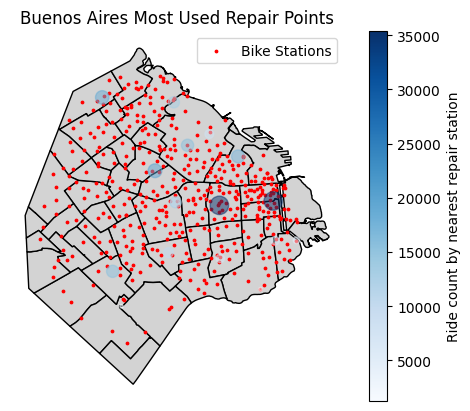

In [108]:
# Set figure size
plt.figure(figsize=(10, 10))

# Plot neighborhood boundaries
ax = gdf_neighborhood_copy.plot(color='lightgray', edgecolor='black')

# Plot specific points (bike stations) with legend
gdf_stations_copy.plot(ax=ax, color='red', markersize=3, label='Bike Stations')

# Plot ride count as bubble plot
bubble_plot = gdf_ordered.plot(ax=ax, column='ride_count', markersize=gdf_ordered['ride_count']/200, alpha=0.5, cmap='Blues')

# Annotate points
for idx, row in gdf_ordered.iterrows():
    # Get coordinates and annotation values
    x, y = row['geometry'].x, row['geometry'].y
    lugar = row['LUGAR']
    ride_count = row['ride_count']


ax.axis('off')

sm = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=gdf_ordered['ride_count'].min(), vmax=gdf_ordered['ride_count'].max()))
sm._A = []  
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('Ride count by nearest repair station')

plt.title('Buenos Aires Most Used Repair Points')
plt.legend()
plt.show()

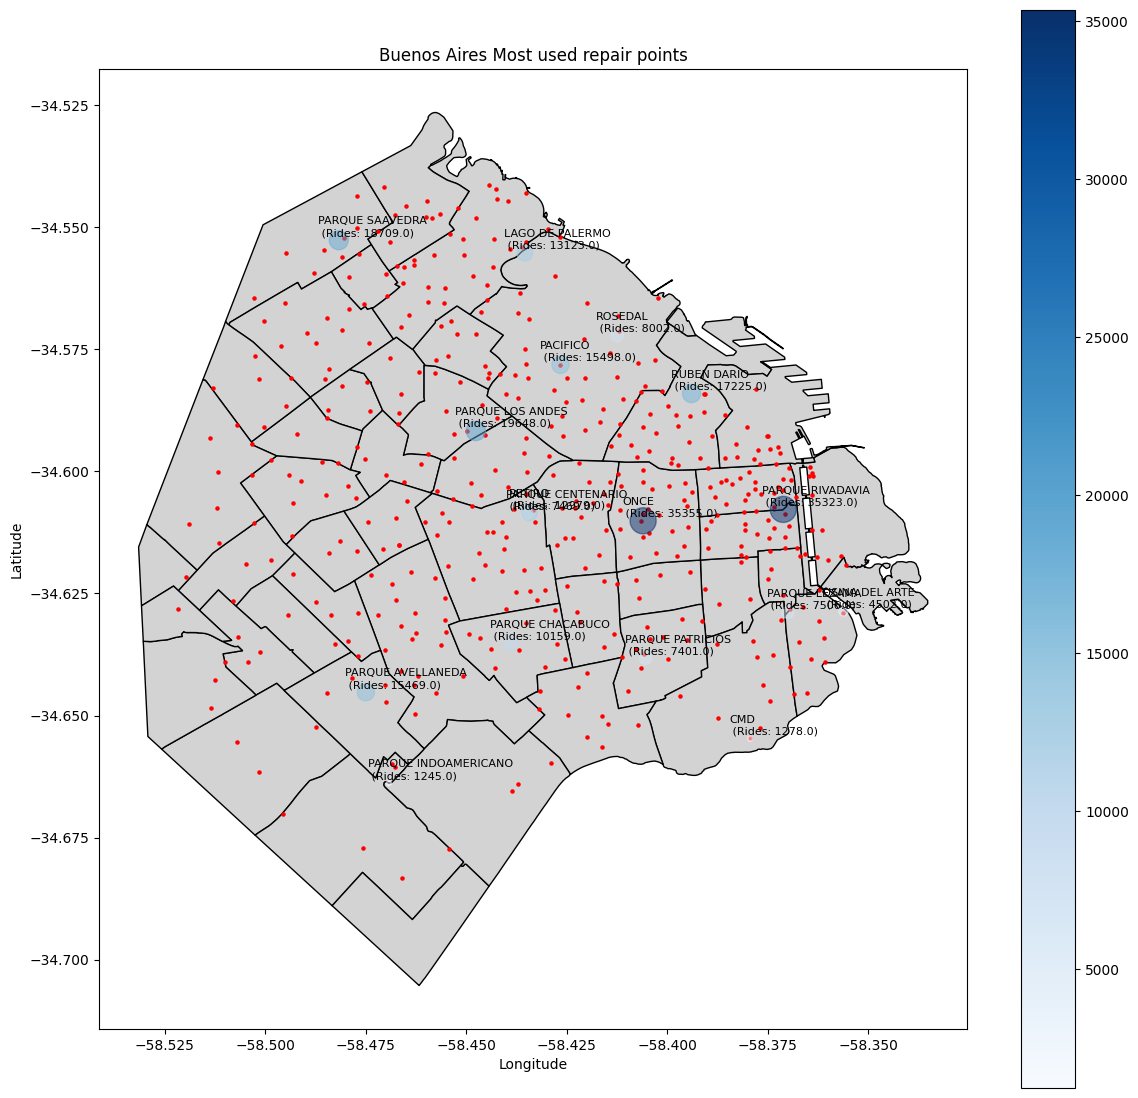

In [109]:
### Original graph

# Plot neighborhood boundaries
ax = gdf_neighborhood_copy.plot(figsize=(14, 14), color='lightgray', edgecolor='black')

# Plot specific points
gdf_stations_copy.plot(ax=ax, color='red', markersize=5)

gdf_ordered.plot(ax=ax, column='ride_count', markersize=gdf_ordered['ride_count']/100, alpha=0.5, cmap='Blues', legend=True)

for idx, row in gdf_ordered.iterrows():
    x, y = row['geometry'].x, row['geometry'].y
    lugar = row['LUGAR']
    ride_count = row['ride_count']
    ax.annotate(f"{lugar}\n (Rides: {ride_count})", xy=(x, y), xytext=(-15, 3), textcoords="offset points", fontsize=8)
    
plt.title('Buenos Aires Most used repair points')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

plt.show()



In [110]:
gdf_ordered

,LUGAR,geometry,station_count,ride_count
12,PARQUE SAAVEDRA,POINT (-58.48171 -34.55266),57,18709.0
4,PARQUE AVELLANEDA,POINT (-58.47496 -34.64523),47,15469.0
7,PARQUE INDOAMERICANO,POINT (-58.46924 -34.66387),6,1245.0
9,PARQUE LOS ANDES,POINT (-58.44760 -34.59170),45,19648.0
6,PARQUE CHACABUCO,POINT (-58.43886 -34.63525),23,10159.0
1,LAGO DE PALERMO,POINT (-58.43539 -34.55526),26,13123.0
5,PARQUE CENTENARIO,POINT (-58.43480 -34.60867),12,7469.0
13,RETIRO,POINT (-58.43424 -34.60850),15,12979.0
3,PACIFICO,POINT (-58.42654 -34.57816),16,15498.0
14,ROSEDAL,POINT (-58.41247 -34.57215),10,8002.0


The results show us that the best place to put a new repair point is near the repair points of Parque Rivadavia or Once, because most of the bike rides origin is near to those. We assume that one would repair their bike after taking it and reaizing its not working properly, not after leaving it because as its not his, they woulnd care about getting fixed, they-ll just take another one.

#### User behaviour - Retention & acquisition

User retention can not be properly tracked, but we do have user_id in the rides dataset, so we can do some estimations to understand the retention and identify improvements needed in the data model to understand the user lifecycle

In [113]:
## Cohort analysis
df_cohort = df_trips_2023_copy[['fecha_origen_recorrido','id_usuario','year_month']].copy()
df_cohort['cohort'] = df_cohort.groupby('id_usuario')['fecha_origen_recorrido'].transform(lambda x: x.min().to_period('M'))
df_cohort2 = df_cohort.groupby(['cohort', 'year_month']).agg(n_customers=('id_usuario', 'nunique')).reset_index(drop=False)
df_cohort2['year_month'] = pd.to_datetime(df_cohort2['year_month']).dt.to_period('M')
df_cohort2['period_number'] = (df_cohort2['year_month'] - df_cohort2['cohort']).apply(lambda x: x.n)

df_cohort2


,cohort,year_month,n_customers,period_number
0,2023-01,2023-01,48738,0
1,2023-01,2023-02,24912,1
2,2023-01,2023-03,21963,2
3,2023-01,2023-04,19266,3
4,2023-01,2023-05,17256,4
...,...,...,...,...
73,2023-10,2023-11,4050,1
74,2023-10,2023-12,2455,2
75,2023-11,2023-11,17039,0
76,2023-11,2023-12,3406,1


In [114]:
cohort_pivot = df_cohort2.pivot_table(index = 'cohort',
                                     columns = 'period_number',
                                     values = 'n_customers')

cohort_size = cohort_pivot.iloc[:,0]
retention_matrix = cohort_pivot.divide(cohort_size, axis = 0)


In [115]:
# Calculate the avg for the colmns
column_averages = retention_matrix.mean()
# Concatenate the retention_matrix and the atotal
average_row = pd.DataFrame(column_averages).transpose()
retention_matrix = pd.concat([retention_matrix, average_row])

retention_matrix.fillna('')

period_number,0,1,2,3,4,5,6,7,8,9,10,11
2023-01,1.0,0.511141,0.450634,0.395297,0.354056,0.316221,0.291067,0.279412,0.277607,0.290984,0.290615,0.271903
2023-02,1.0,0.35699,0.268319,0.227523,0.196279,0.175161,0.169768,0.172238,0.186934,0.181294,0.162111,
2023-03,1.0,0.326361,0.246412,0.202137,0.167277,0.165547,0.166667,0.179949,0.171501,0.14229,,
2023-04,1.0,0.26972,0.19002,0.150139,0.141885,0.136341,0.150895,0.142641,0.113659,,,
2023-05,1.0,0.248025,0.162848,0.150363,0.141672,0.155657,0.143173,0.117731,,,,
2023-06,1.0,0.227049,0.167424,0.149063,0.15512,0.146129,0.110449,,,,,
2023-07,1.0,0.231655,0.156758,0.152026,0.136583,0.112212,,,,,,
2023-08,1.0,0.270918,0.213527,0.182415,0.138551,,,,,,,
2023-09,1.0,0.287068,0.199611,0.144627,,,,,,,,
2023-10,1.0,0.242225,0.14683,,,,,,,,,


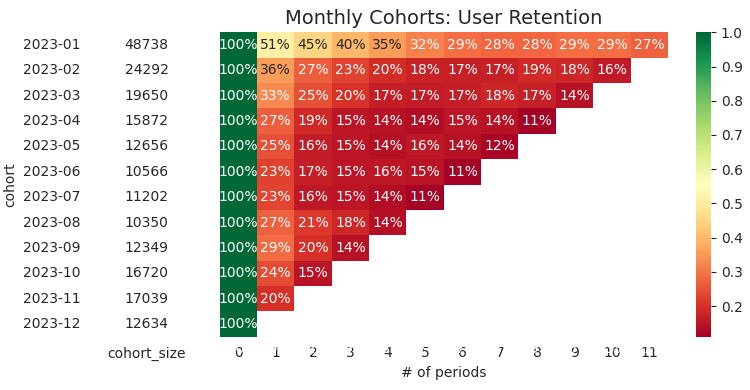

In [116]:
with sns.axes_style("white"):
    fig, ax = plt.subplots(1, 2, figsize=(8, 4), sharey=True, gridspec_kw={'width_ratios': [1, 5]})
    sns.heatmap(retention_matrix, 
                mask=retention_matrix.isnull(), 
                annot=True, 
                fmt='.0%', 
                cmap='RdYlGn', 
                ax=ax[1])
    ax[1].set_title('Monthly Cohorts: User Retention', fontsize=14)  
    ax[1].set(xlabel='# of periods',
              ylabel='')

    cohort_size_df = pd.DataFrame(cohort_size).rename(columns={0: 'cohort_size'})
    white_cmap = mcolors.ListedColormap(['white'])
    sns.heatmap(cohort_size_df, 
                annot=True, 
                cbar=False, 
                fmt='g', 
                cmap=white_cmap, 
                ax=ax[0])

    fig.tight_layout()

plt.show() 

In [117]:
column_averages

period_number
0     1.000000
1     0.288277
2     0.220238
3     0.194844
4     0.178928
5     0.172467
6     0.172003
7     0.178394
8     0.187425
9     0.204856
10    0.226363
11    0.271903
dtype: float64

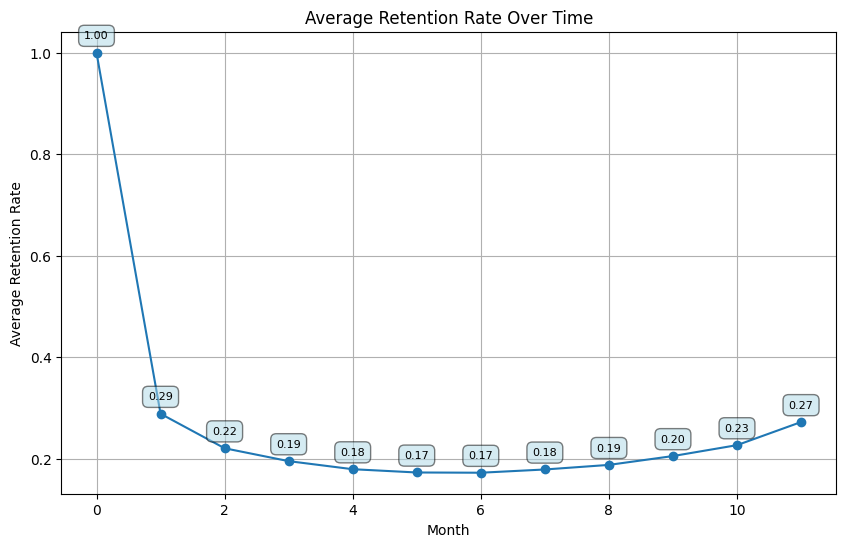

In [118]:
## Plot a retention curve
column_averages = retention_matrix.mean()

average_row = pd.DataFrame(column_averages).transpose()
plt.figure(figsize=(10, 6))
plt.plot(average_row.columns, average_row.values.flatten(), marker='o')

for i, value in enumerate(average_row.values.flatten()):
    plt.annotate(f'{value:.2f}', (average_row.columns[i], value),
                 textcoords="offset points", xytext=(0,10),
                 ha='center', fontsize=8,
                 bbox=dict(boxstyle='round,pad=0.5', fc='lightblue', alpha=0.5))

plt.xlabel('Month')
plt.ylabel('Average Retention Rate')
plt.title('Average Retention Rate Over Time')

plt.grid(True)
plt.show()

In [119]:
# Calculate the growth mom as a percentage
cohort_size_df['growth'] = round((cohort_size_df['cohort_size'].diff() / cohort_size_df['cohort_size'].shift(1)) * 100,2)

print(cohort_size_df)

         cohort_size  growth
cohort                      
2023-01      48738.0     NaN
2023-02      24292.0  -50.16
2023-03      19650.0  -19.11
2023-04      15872.0  -19.23
2023-05      12656.0  -20.26
2023-06      10566.0  -16.51
2023-07      11202.0    6.02
2023-08      10350.0   -7.61
2023-09      12349.0   19.31
2023-10      16720.0   35.40
2023-11      17039.0    1.91
2023-12      12634.0  -25.85


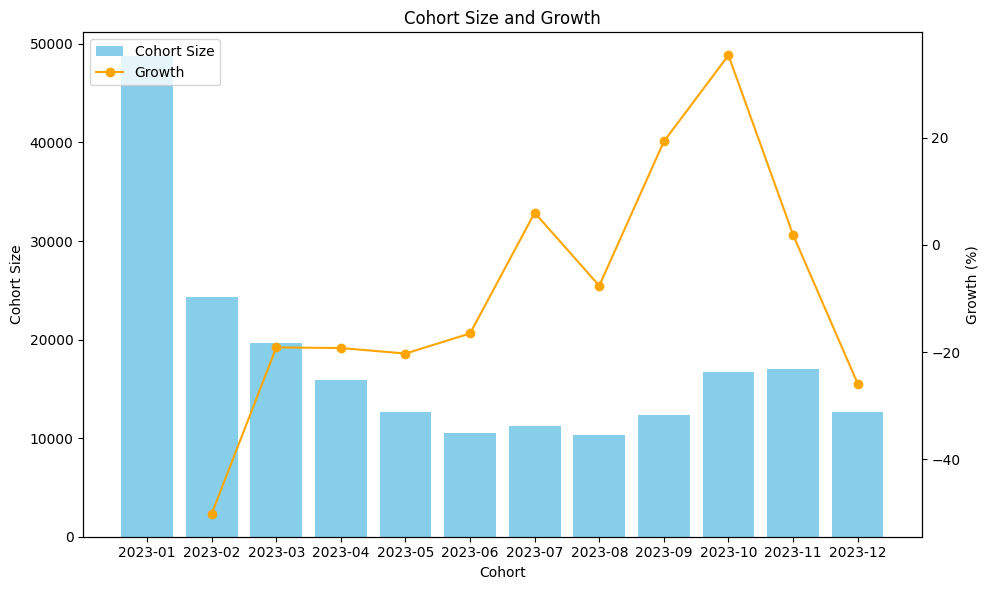

In [120]:
## Plot acquisition trend
cohort_size_df.index = cohort_size_df.index.astype(str)


plt.figure(figsize=(10, 6))

ax1 = plt.gca()

ax1.bar(cohort_size_df.index, cohort_size_df['cohort_size'], color='skyblue', label='Cohort Size')

ax1.set_xlabel('Cohort')
ax1.set_ylabel('Cohort Size')
ax1.set_title('Cohort Size and Growth')

ax2 = ax1.twinx()

ax2.plot(cohort_size_df.index, cohort_size_df['growth'], marker='o', color='orange', label='Growth')

ax2.set_ylabel('Growth (%)')

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

plt.tight_layout()
plt.show()

There is not only a problem with retention but with acquisition too

Potential improvements for the data model
- Link Ride Records to User IDs: Associate user IDs with ride records to track individual activity.
- Capture User Profiles: Gather user profile data for segmentation purposes.
- Implement Event Tracking: Log user interactions to understand engagement levels.
- Enhance Data for Cohort Analysis: Update data schema to facilitate cohort analysis for evaluating retention metrics.

#### Bikes redistribution initial assesment

Logic used:
- Estimate total bikes in the system based on public info: 4k bikes 
- Identify total parkin spots based on real data: 8.5k
- Estimate bikes available at peak origin station (half of parking spots).
- Identify peak demand window (20 min).
- Find station with most trip origins during peak.
- Calculate bike repositioning rate.
- If demand is higher in the next window, then consider redistribution

In [134]:
## Identify the demand peak, using intervanls of 20 min as thats above the median ride time
df_trips_2023_copy['interval_start'] = df_trips_2023_copy['fecha_origen_recorrido'].dt.floor('20min')

df_trips_2023_copy['interval_end'] = df_trips_2023_copy['fecha_destino_recorrido'].dt.floor('20min') + pd.Timedelta(minutes=20)

interval_counts_start = df_trips_2023_copy.groupby('interval_start').agg(bike_use=('Id_recorrido', 'nunique')).reset_index()
interval_counts_end = df_trips_2023_copy.groupby('interval_end').agg(bike_use=('Id_recorrido', 'nunique')).reset_index()

interval_counts_start.rename(columns={'Id_recorrido': 'bike_use'}, inplace=True)

interval_counts_start = interval_counts_start.sort_values(by='bike_use', ascending=False)

interval_counts_start.head(3)

,interval_start,bike_use
21399,2023-10-25 18:00:00,474
13493,2023-07-07 17:00:00,472
7179,2023-04-10 18:00:00,467


In [136]:
interval_counts_end.rename(columns={'Id_recorrido': 'bike_use'}, inplace=True)

interval_counts_end = interval_counts_end.sort_values(by='bike_use', ascending=False)
interval_counts_end.head(3)

,interval_end,bike_use
7180,2023-04-10 18:40:00,438
13498,2023-07-07 18:00:00,437
23426,2023-11-22 18:40:00,432


In [137]:
max_use_system = df_trips_2023_copy[df_trips_2023_copy['interval_start'] == '2023-10-25 18:00:00']

max_count_origin = max_use_system.groupby('nombre_estacion_origen')['nombre_estacion_origen'].count().reset_index(name='total')
max_top_origin_stations = max_count_origin.sort_values(by='total',ascending=False).reset_index()
max_top_origin_stations

,index,nombre_estacion_origen,total
0,177,292 - PLAZA BOLIVIA,8
1,23,035 - INGENIERO BUTTY,7
2,98,152 - JULIETA LANTERI,7
3,73,111 - MACACHA GUEMES,7
4,134,207 - PLAZA ARENALES,7
...,...,...,...
209,135,216 - EMILIO LAMARCA,1
210,60,091 - Pasco,1
211,132,201 - PLAZA EJERCITO DE LOS ANDES,1
212,63,094 - GÚZMAN,1


In [138]:
max_use_system_end = df_trips_2023_copy[df_trips_2023_copy['interval_end'] == '2023-10-25 18:00:00']
max_count_end = max_use_system.groupby('nombre_estacion_destino')['nombre_estacion_destino'].count().reset_index(name='total')
max_top_end_stations = max_count_end.sort_values(by='total',ascending=False).reset_index()
max_top_end_stations


,index,nombre_estacion_destino,total
0,91,147 - Constitución,10
1,177,292 - PLAZA BOLIVIA,8
2,209,368 - PLAZA DE LA SHOÁ,7
3,202,352 - San Jose de Flores,7
4,120,187 - Jose Maria Moreno,7
...,...,...,...
221,24,034 - Colonia Express,1
222,25,036 - MAIPÚ,1
223,116,182 - RAVIGNANI Y GUATEMALA,1
224,26,037- Claudia Pía Baudracco,1


Too many estimations and lack of data to get a proper answer, but the logic would be the mentioned above once data model is good enough.